<a href="https://colab.research.google.com/github/sbb2002/Portfolio/blob/main/.study/Tensorflow/ML_ch12_3_RNN_stock_market_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN with time-series data (stock market)

주식 시장에 대해 예측해봅시당. Many-to-one 모형을 이용하는데 input으로 1~7일까지를 넣고, 8일째의 주식가격을 예측하라고 시키는 식이다. 당연히 8일째 예측값은 FC를 거쳐 final output을 낸다.

In [ ]:
!pip install tensorflow==1.14

     |████████████████████████████████| 109.3MB 109kB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 491kB 61.9MB/s 
     |████████████████████████████████| 3.2MB 48.4MB/s 
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.14.0 which is incompatible.
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


In [ ]:
!pip install tensorflow-gpu==1.14

     |████████████████████████████████| 377.1MB 52kB/s 


In [ ]:
!pip install matplotlib==2.0.0

In [ ]:
!git clone https://github.com/hunkim/DeepLearningZeroToAll/

Cloning into 'DeepLearningZeroToAll'...
remote: Enumerating objects: 1709, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 1709 (delta 2), reused 1 (delta 1), pack-reused 1697
Receiving objects: 100% (1709/1709), 751.23 KiB | 15.02 MiB/s, done.
Resolving deltas: 100% (1111/1111), done.


In [ ]:
!find ./ -name  data-02-stock_daily.csv

./DeepLearningZeroToAll/data-02-stock_daily.csv
./DeepLearningZeroToAll/mxnet/data-02-stock_daily.csv
./DeepLearningZeroToAll/keras/data-02-stock_daily.csv
./DeepLearningZeroToAll/pytorch/data-02-stock_daily.csv


In [ ]:
tf.reset_default_graph()

NameError: ignored

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib
import os

tf.set_random_seed(777)

if "DISPLAY" not in os.environ:
  # remove Travis CI error
  matplotlib.use('Agg')

import matplotlib.pyplot as plt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
def MinMaxScaler(data):
  ''' Min Max Normalization

  Parameters
  -----------
  data : numpy.ndarry
  normalized data
  shape: [Batch size, dimension]

  ReferenceError
  ----------
  .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
  '''
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  # noise term prevents the zero division
  return numerator / (denominator + 1e-7)

In [ ]:
# train params
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [ ]:
# Open, High, Low, Volume, Close
xy = np.loadtxt('./DeepLearningZeroToAll/data-02-stock_daily.csv', delimiter=',')
xy = xy[::-1]     # revere order (chronically ordered)

In [ ]:
# train.test split
train_size = int(len(xy) * 0.7)
train_set = xy[0 : train_size]
test_set = xy[train_size - seq_length : ]    # Index from [train_size - seq_length] to utilize past sequence

In [ ]:
# Scale each
train_set = MinMaxScaler(train_set)
test_set = MinMaxScaler(test_set)

In [ ]:
# build datasets
def build_dataset(time_series, seq_length):
  dataX = []
  dataY = []
  for i in range(0, len(time_series) - seq_length):
    _x = time_series[i:i + seq_length, :]
    _y = time_series[i + seq_length, [-1]]    # Next close price
    print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)
  return np.array(dataX), np.array(dataY)

In [ ]:
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# input placeholders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)   # We use the last cell's output

# cost
loss = tf.reduce_sum(tf.square(Y_pred - Y))     # sum of the squares

# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 [0.18685758 0.18212236 0.1560484  0.60962624 0.15331987]
 [0.14300667 0.13856872 0.13617972 0.22934481 0.12698631]
 [0.1172689  0.14037216 0.1430174  0.21129336 0.14877846]
 [0.13503702 0.12893923 0.13850679 0.18323922 0.12107173]
 [0.12220255 0.12138537 0.12372168 0.16807385 0.11480508]
 [0.09611997 0.09773711 0.09973633 0.18754145 0.08319064]] -> [0.08660558]
[[0.18685758 0.18212236 0.1560484  0.60962624 0.15331987]
 [0.14300667 0.13856872 0.13617972 0.22934481 0.12698631]
 [0.1172689  0.14037216 0.1430174  0.21129336 0.14877846]
 [0.13503702 0.12893923 0.13850679 0.18323922 0.12107173]
 [0.12220255 0.12138537 0.12372168 0.16807385 0.11480508]
 [0.09611997 0.09773711 0.09973633 0.18754145 0.08319064]
 [0.07773084 0.07698102 0.05455784 0.29825222 0.08660558]] -> [0.12374741]
[[0.14300667 0.13856872 0.13617972 0.22934481 0.12698631]
 [0.1172689  0.14037216 0.1430174  0.21129336 0.14877846]
 [0.13503702 0.12893923 0.13850679 0.18323922 0.12107173]
 [

[step: 0] loss: 166.2140655517578
[step: 1] loss: 105.05767822265625
[step: 2] loss: 59.56279373168945
[step: 3] loss: 29.21882438659668
[step: 4] loss: 14.212986946105957
[step: 5] loss: 13.826704978942871
[step: 6] loss: 22.126537322998047
[step: 7] loss: 28.972867965698242
[step: 8] loss: 29.148345947265625
[step: 9] loss: 24.057565689086914
[step: 10] loss: 17.07508087158203
[step: 11] loss: 10.876200675964355
[step: 12] loss: 6.789780616760254
[step: 13] loss: 4.991913318634033
[step: 14] loss: 4.958413600921631
[step: 15] loss: 5.900998115539551
[step: 16] loss: 7.070884704589844
[step: 17] loss: 7.916769981384277
[step: 18] loss: 8.13344669342041
[step: 19] loss: 7.646057605743408
[step: 20] loss: 6.564518928527832
[step: 21] loss: 5.126851558685303
[step: 22] loss: 3.6374006271362305
[step: 23] loss: 2.3999364376068115
[step: 24] loss: 1.6473324298858643
[step: 25] loss: 1.4777247905731201
[step: 26] loss: 1.8182681798934937
[step: 27] loss: 2.442272901535034
[step: 28] loss: 3

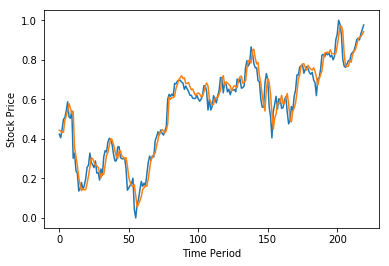

In [ ]:
with tf.Session() as sess:
  init = tf.global_variables_initializer()
  sess.run(init)

  # Training step
  for i in range(iterations):
    _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    print("[step: {}] loss: {}".format(i, step_loss))

  # Test step
  test_predict = sess.run(Y_pred, feed_dict={X: testX})
  rmse_val = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
  print("RMSE: {}".format(rmse_val))

  # Plot predictions
  plt.plot(testY)
  plt.plot(test_predict)
  plt.xlabel("Time Period")
  plt.ylabel("Stock Price")
  plt.show()